Processing and Training Splits
---

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
total_set = pd.read_json('../data/interim/Step 2 - Total Set.json', orient='records', convert_axes=False)
train_set = pd.read_json('../data/interim/Step 2 - Train Set.json', orient='records', convert_axes=False)
test_set = pd.read_json('../data/interim/Step 2 - Test Set.json', orient='records', convert_axes=False)

Just now realized we've been accumulating a extra index columns. Let's drop them. We can re-engineer the "Id" column later by adding 1 to each index value.

In [3]:
total_set.drop(['index', 'Id'], axis=1, inplace=True)
train_set.drop(['index', 'Id'], axis=1, inplace=True)
test_set.drop(['index', 'Id'], axis=1, inplace=True)

TO REMOVE
----

In [4]:
total_set['LandSlope'].replace({5:'Mod', 2:'Sev'}, inplace=True)
train_set = total_set[total_set['set'] == 'train']
test_set = total_set[total_set['set'] == 'test']

Step 1: Clean & One-Hot Categorical Variables
---

Since we converted all ordinal categorical features into numerical features in the previous step, we can skip straight to one-hotting the remaining ones.

BUT! "Condition1"/"Condition2" and "Exterior1st"/"Exterior2nd" are weird. They're pairs of columns that allow for more than one value to be recorded for the given category. So they require an extra step - after they're one-hotted, we should combine their columns in pairs such that every feature that is present will be represented without duplication.

In [5]:
o_cols = total_set.select_dtypes(include=['object'])
o_cols.columns

Index(['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'set'],
      dtype='object')

In [6]:
o_cols.isnull().sum()

MSZoning            4
Street              0
Alley            2721
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
Foundation          0
Heating             0
Electrical          1
GarageType        157
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
set                 0
dtype: int64

Oh no! Nulls. Let's deal with them, then, I *guess*...

...but if the missing values occur in our test set, we can't mess with them unless we do so under predefined rules that can be applied to any future data sets with equal effectiveness (and obviously we can't drop them). So let's just look at our training set for now.

In [7]:
o_cols[o_cols['set']=='train'].isnull().sum()

MSZoning            0
Street              0
Alley            1369
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
Foundation          0
Heating             0
Electrical          1
GarageType         81
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
set                 0
dtype: int64

Looks like a LOT of the missing values were in the test set only. So let's just make up rules for any future set we get. The rules should be specific to each column and applicable to any future test set.

I went through the value counts for each column to arrive at these, but that's boring and takes up a lot of notebook space, so I omitted that here.

Let's draft this as a function so that we can reapply it uniformly to any new records.

First, we'll create the dictionary used for any future sets, and then 'store' it for future use.

In [8]:
cat_fillna_dict = {
    'Neighborhood':'Other',
    'Exterior1st':'Other',
    'Exterior2nd':'Other',
    'Foundation':'Other',
    'Alley':'NA',
    'GarageType':'NA',
    'Fence':'NA',
    'MiscFeature':'NA',
    'Condition1':'Norm',
    'Condition2':'Norm',
}

to_mode = ['LandContour', 'Street', 'MSZoning', 'Utilities', 'LotConfig', \
           'LandSlope', 'BldgType', 'HouseStyle', 'RoofMatl', 'MasVnrType', \
            'Heating', 'Electrical', 'SaleType', 'SaleCondition']

# Be sure to get the mode of the TRAINING set, to avoid bleed.
for col in to_mode :
    cat_fillna_dict[col] = train_set[col].mode()[0]

%store cat_fillna_dict

Stored 'cat_fillna_dict' (dict)


In [9]:
def cat_fillna(df) :
    """Fills NA values of non-ordinal categorical features for this data set.
    
    df is a dataframe (presumably a new test set) which must have the same columns as the original set these notebooks are based on.

    Uses the %stored dictionary 'cat_fillna_dict' to determine the .fillna() values.

    """
    
    %store -r cat_fillna_dict

    for col in cat_fillna_dict :
        df[col].fillna(value=cat_fillna_dict[col], inplace=True)
    return df

In [10]:
total_set = cat_fillna(total_set)

In [11]:
o_cols = total_set.select_dtypes(include=['object'])
o_cols.isnull().sum()

MSZoning         0
Street           0
Alley            0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
Electrical       0
GarageType       0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
set              0
dtype: int64

Now we're ready to one-hot!

In [12]:
cat_vars = list(o_cols.columns)
cat_vars.remove('set')

for col in cat_vars :
    oh = pd.get_dummies(total_set[col], prefix=col).astype(int)
    total_set = total_set.join(oh, on=None).drop(col, axis=1)

And now let's fix the Condition and Exterior column pairs.

In [13]:
# First let's get all our relevant columns.
# We only need the second of each pair, since we can use that to derive the first of each pair.

condition2_cols = []
exterior2_cols = []

for col in total_set.columns :
    if "Condition2" in col :
        condition2_cols.append(col)
    if "Exterior2" in col :
        exterior2_cols.append(col)


The first time I executed this bit, I didn't get the values I expected.

As you can see below, Condition2_Artery has 5 true values in the Condition2 version and 92 in the Condition 1 version.
Thus I expected the number of true values after combination to be 97. However, it was 95.
This is because some values are true in both Condition1 and Condition2 columns.
I will consider this to be an input error and ignore it in the function that follows.

In [14]:
for col in condition2_cols :
    print(col[10:], total_set[col].sum(), total_set[col[:9]+'1'+col[10:]].sum())

_Artery 5 92
_Feedr 13 164
_Norm 2889 2511
_PosA 4 20
_PosN 4 39
_RRAe 1 28
_RRAn 1 50
_RRNn 2 9


In [15]:
total_set[total_set['Condition2_Artery'] == 1]['Condition1_Artery'] 

9       1
1186    1
2110    0
2238    0
2455    0
Name: Condition1_Artery, dtype: int32

In [16]:
# Now let's find all the 1s in the second of these pairs and copy them to the first of the pairs, then drop the second of the pairs.
# It's kind of annoying, but we can manually change the 2 to a 1 in the col name string.

for index, row in total_set.iterrows() :
    for col in condition2_cols :
        # The "Norm" thing is basically the filler value, so we should ignore it.
        if col != 'Condition2_Norm' :
            if total_set.loc[index, col] == 1 :
                new_col = col[:9]+'1'+col[10:]
                total_set.loc[index, new_col] = 1

# Now we remove the Condition2 columns.
total_set.drop(condition2_cols, axis=1, inplace=True)

# And the same for Exterior:
for index, row in total_set.iterrows() :
    for col in exterior2_cols :
        if total_set.loc[index, col] == 1 :
            new_col = col[:8]+'1st'+col[11:]
            total_set.loc[index, new_col] = 1

# And presto.
total_set.drop(exterior2_cols, axis=1, inplace=True)

In [17]:
total_set['Condition1_Artery'].sum()

95

Only now did I realize that there's a typo in one of the Exterior values!

'Wood Shingles' is keyed as 'WdShing' in the training set and 'Wd Shing' in the test set.

Let's just combine those columns, then.

In [18]:
for index, row in total_set.iterrows() :
    if row['Exterior1st_Wd Shng'] == 1 :
        total_set.loc[index, 'Exterior1st_WdShing'] = 1

total_set.drop('Exterior1st_Wd Shng', axis=1, inplace=True)

I've also noted that one of the values in the BldgType column is out of step with the documentation.

'twnhs' isn't in the documentation, and should apparently be either 'TwhsE' or 'TwnhsI', but we have no way of seeing which.

Let's see if it even matters...

C:\Users\Josh\AppData\Local\Temp\ipykernel_24764\892015935.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='BldgType', y='SalePrice', data=small_df, palette='colorblind')
c:\Users\Josh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Josh\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


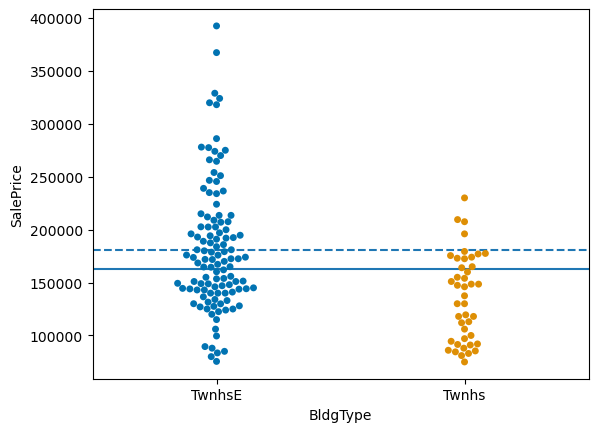

In [19]:
small_df = train_set[(train_set['BldgType']=='TwnhsE') | (train_set['BldgType']=='Twnhs')]

sns.swarmplot(x='BldgType', y='SalePrice', data=small_df, palette='colorblind')
plt.axhline(train_set['SalePrice'].mean(), linestyle='--')
plt.axhline(train_set['SalePrice'].median())


Kinda seems like it does...

In [20]:
from scipy.stats import ks_2samp

In [21]:
TwnhsE = train_set[train_set['BldgType']=='TwnhsE']['SalePrice']
Twnhs = train_set[train_set['BldgType']=='Twnhs']['SalePrice']
stat, p_val = ks_2samp(TwnhsE, Twnhs)
print("P-value between TwnhsE and Twnhs sale price distributions: "+str(round(p_val, 6)))

P-value between TwnhsE and Twnhs sale price distributions: 0.000346


Yeah, probably does. Let's make the BOLD assumption that Twnhs is supposed to be TwnhsI, and convert all future Twnhs values to TwnhsI, in keeping with the documentation.

In [22]:
def townhouse(df) :
    df.replace({'Twnhs':"TwnhsI"}, inplace=True)
    return df

In [23]:
train_set = townhouse(train_set)
test_set = townhouse(test_set)
train_set['BldgType'].value_counts()

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
TwnhsI      43
2fmCon      31
Name: count, dtype: int64

And let's backfill that for our already one-hotted df.

In [24]:
total_set.rename(columns={"BldgType_Twnhs":"BldgType_TwnhsI"}, inplace=True)

Step 2: Preparing the Numeric Columns
--

Let's make sure we don't have any nulls left over from last time.

In [25]:
n_cols = [name for name in total_set.columns if "_" not in name]
n_cols.remove('SalePrice')

n_df = total_set[n_cols]
n_df

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,set
0,60,65.0,8450,4,7,5,2003,2003,196.0,4,...,61,0,0,0,0,NaN,0,2,2008,train
1,20,80.0,9600,4,6,8,1976,1976,0.0,3,...,0,0,0,0,0,NaN,0,5,2007,train
2,60,68.0,11250,3,7,5,2001,2002,162.0,4,...,42,0,0,0,0,NaN,0,9,2008,train
3,70,60.0,9550,3,7,5,1915,1970,0.0,3,...,35,272,0,0,0,NaN,0,2,2006,train
4,60,84.0,14260,3,8,5,2000,2000,350.0,4,...,84,0,0,0,0,NaN,0,12,2008,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,4,7,1970,1970,0.0,3,...,0,0,0,0,0,NaN,0,6,2006,test
2915,160,21.0,1894,4,4,5,1970,1970,0.0,3,...,24,0,0,0,0,NaN,0,4,2006,test
2916,20,160.0,20000,4,5,7,1960,1996,0.0,3,...,0,0,0,0,0,NaN,0,9,2006,test
2917,85,62.0,10441,4,5,5,1992,1992,0.0,3,...,32,0,0,0,0,NaN,700,7,2006,test


In [26]:
n_df.isnull().sum()

MSSubClass          0
LotFrontage       486
LotArea             0
LotShape            0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
ExterQual           0
ExterCond           0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
HeatingQC           0
CentralAir          0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
Functional          0
Fireplaces          0
FireplaceQu      1420
GarageFinish      159
GarageArea          1
GarageQual        159
GarageCond        159
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea  

I guess we have to go through and define interpolation methods for each of them now.

I've checked the documentation & all value counts, but am only leaving one example in the notebook.

PoolQC
4.0    3
5.0    2
2.0    2
Name: count, dtype: int64


<Axes: >

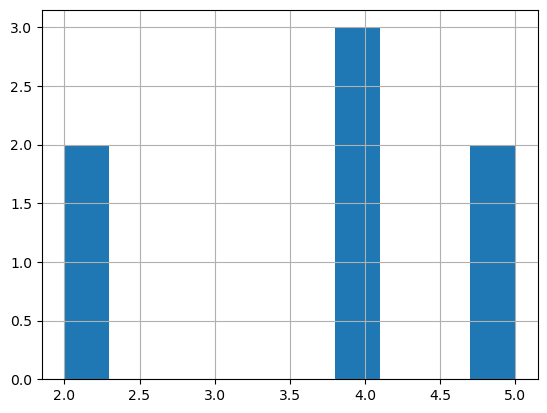

In [27]:
x = 'PoolQC'
print(n_df[n_df['set'] == 'train'][x].value_counts())
n_df[n_df['set'] == 'train'][x].hist()
# n_df[(n_df['set'] == 'train') & (n_df['LotArea'] < 60000)][x].hist()

The following are my decisions RE how to impute the values for each column.

In [28]:
median = ['LotArea', 'OverallQual', 'GrLivArea', 'MSSubClass']
mode = ['LotFrontage', 'LotShape', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
        'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'FullBath', 'BedroomAbvGr', \
        'KitchenAbvGr', 'KitchenQual', 'Functional', 'GarageFinish', 'PavedDrive', ]
zero = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', \
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', \
        'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageArea', 'GarageQual', \
        'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
        'PoolArea', 'PoolQC']

Now let's IMPUUUUTE

In [29]:
experiment = total_set.copy()

for col in median :
    med = total_set[total_set['set'] == 'train'][col].median()
    total_set[col].fillna(med, inplace=True)
for col in mode :
    mod = total_set[total_set['set'] == 'train'][col].mode().iloc[0]
    total_set[col].fillna(mod, inplace=True)
for col in zero :
    total_set[col].fillna(0, inplace=True)

total_set.isnull().sum()

MSSubClass                  0
LotFrontage                 0
LotArea                     0
LotShape                    0
OverallQual                 0
                         ... 
SaleCondition_Family        0
SaleCondition_Normal        0
SaleCondition_Partial       0
Exterior1st_CmentBd      2793
Exterior1st_Brk Cmn      2897
Length: 208, dtype: int64

Why still nulls?

In [30]:
for col in total_set.columns :
    nulls = total_set[col].isnull().sum()
    if nulls > 0 :
        print(col, nulls)

SalePrice 1459
Exterior1st_CmentBd 2793
Exterior1st_Brk Cmn 2897


Really no idea how those two one-hot cols ended up with nulls, but fortunately the only prescription is more cowbell.

In [31]:
print(total_set['Exterior1st_CmentBd'].value_counts())
print(total_set['Exterior1st_Brk Cmn'].value_counts())

Exterior1st_CmentBd
1.0    126
Name: count, dtype: int64
Exterior1st_Brk Cmn
1.0    22
Name: count, dtype: int64


In [32]:
total_set['Exterior1st_CmentBd'].fillna(0.0, inplace=True)
total_set['Exterior1st_Brk Cmn'].fillna(0.0, inplace=True)

NOW we're cooking with grease. And finally, to scale...

In [33]:
# I'm so far behind, I'm just running with an MVP approach here, so I'm not checking everything
# for outliers again.

scaler = StandardScaler()

numerics = n_cols

numerics.pop(-1)

for col in numerics :
    # Only fit the scaler to the training set.
    scaler.fit(total_set[total_set['set']=='train'][[col]])
    # Use the fit scaler to transform both sets.
    scaler.transform(total_set[[col]])

Step 3: Train Test Split
--

In [34]:
train_set = total_set[total_set['set']=='train']

train_set.drop(columns=['set'], inplace=True)

X = train_set.drop(columns=['SalePrice'])
y = train_set['SalePrice']

C:\Users\Josh\AppData\Local\Temp\ipykernel_24764\408304157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(columns=['set'], inplace=True)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: Save and Quit
--

In [36]:
total_set.to_json('../data/Step 3 - Total Set.json', orient='records')
X_train.to_json('../data/Step3 - X_train.json', orient='records')
X_test.to_json('../data/Step3 - X_test.json', orient='records')
y_train.to_json('../data/Step3 - y_train.json', orient='records')
y_test.to_json('../data/Step3 - y_test.json', orient='records')

Appendix: Further Refinements
--

In [37]:
# NOTE: This cell is to deal with the BsmtFinType1 and BsmtFinType2 problem.



In [38]:
# NOTE: Should we implement conditional imputation?
# For example, if 'GarageArea' is 0, we automatically set 'GarageQual' to 0.
# But if 'GarageArea is not 0, we set 'GarageQual' to the median 'GarageQual'.